# Step 1 & 2

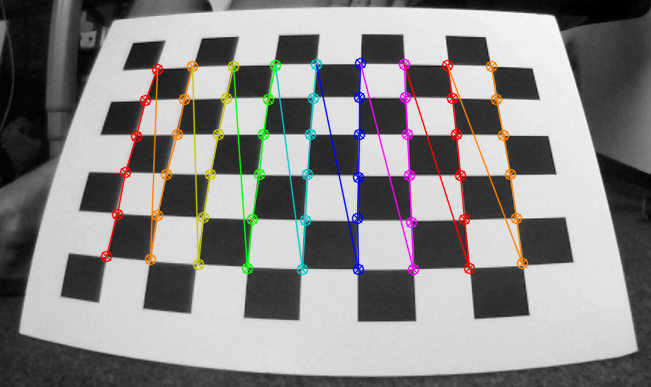

In [5]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow


img = cv2.imread(r'/content/Distorted.PNG')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

checkerboard_size = (6, 9)


ret, corners = cv2.findChessboardCorners(gray, checkerboard_size, None)

if ret:
    img = cv2.drawChessboardCorners(img, checkerboard_size, corners, ret)
    cv2_imshow(img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

# Step 3 & 4

In [6]:
import cv2
import numpy as np
import glob
import os


checkerboard_size = (6, 9)

objp = np.zeros((checkerboard_size[0] * checkerboard_size[1], 3), np.float32)
objp[:, :2] = np.mgrid[0:checkerboard_size[0], 0:checkerboard_size[1]].T.reshape(-1, 2)


objpoints = []
imgpoints = []


image_folder = r'/content/images'



image_files = glob.glob(os.path.join(image_folder, '*.jpg'))

for fname in image_files:
    img = cv2.imread(fname)

    if img is None:
        print(f"Warning: Could not read {fname}")
        continue

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, checkerboard_size, None)

    if ret:
        objpoints.append(objp)
        imgpoints.append(corners)



ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

print("Camera Matrix:\n", mtx)
print("Distortion Coefficients:\n", dist)


Camera Matrix:
 [[766.01640733   0.         324.90986108]
 [  0.         768.83917549 271.36658781]
 [  0.           0.           1.        ]]
Distortion Coefficients:
 [[-7.43652983e-02 -7.41027869e-01  3.39390748e-03  1.67025119e-03
   6.39394714e+00]]


# Step 5

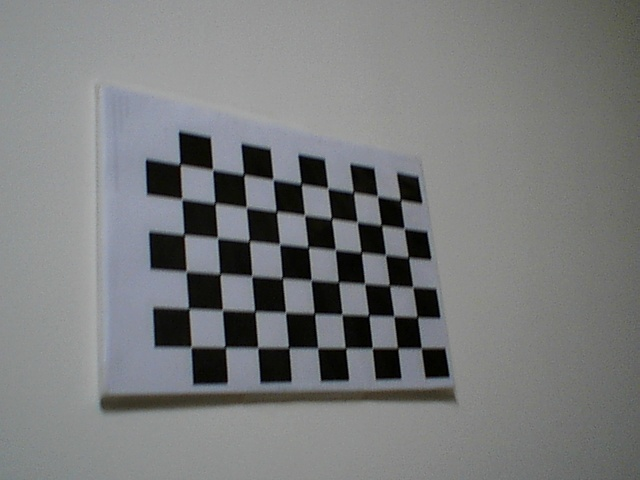

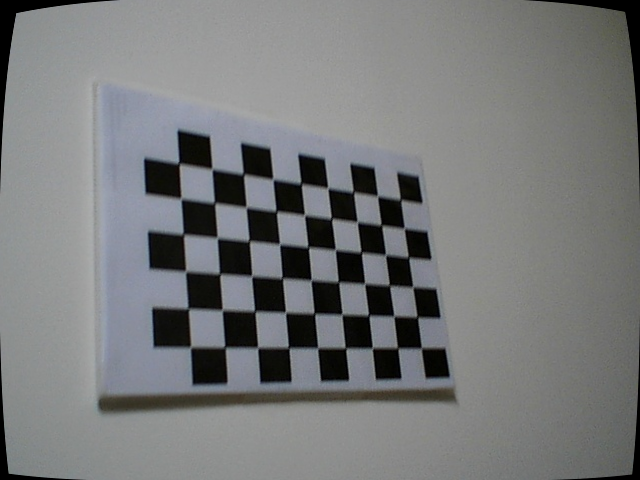

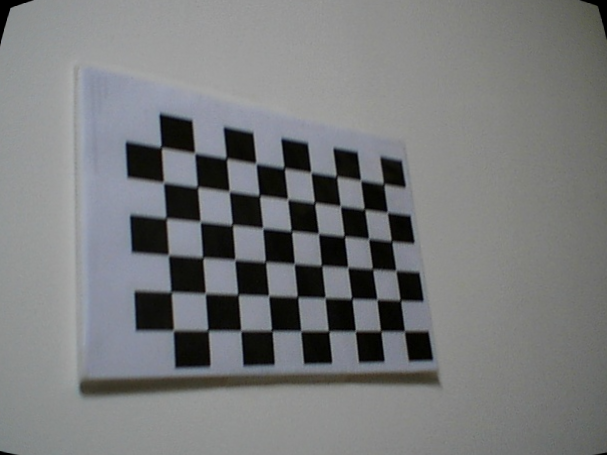

In [9]:
import cv2
import numpy as np

if 'mtx' not in globals() or 'dist' not in globals():
    print("Error: Camera calibration parameters (mtx, dist) not found. Run calibration first.")
    exit()


img = cv2.imread(r'/content/images/19.jpg')


if img is None:
    print("Error: Could not read the image file. Please check the path.")
    exit()


h, w = img.shape[:2]


def apply_distortion(img, mtx, dist):
    distorted_img = cv2.undistort(img, mtx, dist, None, mtx)
    return distorted_img

distorted_img = apply_distortion(img, mtx, dist)


new_camera_mtx, roi = cv2.getOptimalNewCameraMatrix(mtx, dist, (w, h), 1, (w, h))


undistorted_img = cv2.undistort(distorted_img, mtx, dist, None, new_camera_mtx)


x, y, w, h = roi
undistorted_img = undistorted_img[y:y+h, x:x+w]


cv2_imshow(img)
cv2_imshow(distorted_img)
cv2_imshow(undistorted_img)
cv2.waitKey(0)
cv2.destroyAllWindows()


# Bonus

Camera Matrix:
 [[766.01640733   0.         324.90986108]
 [  0.         768.83917549 271.36658781]
 [  0.           0.           1.        ]]
Distortion Coefficients:
 [[-7.43652983e-02 -7.41027869e-01  3.39390748e-03  1.67025119e-03
   6.39394714e+00]]


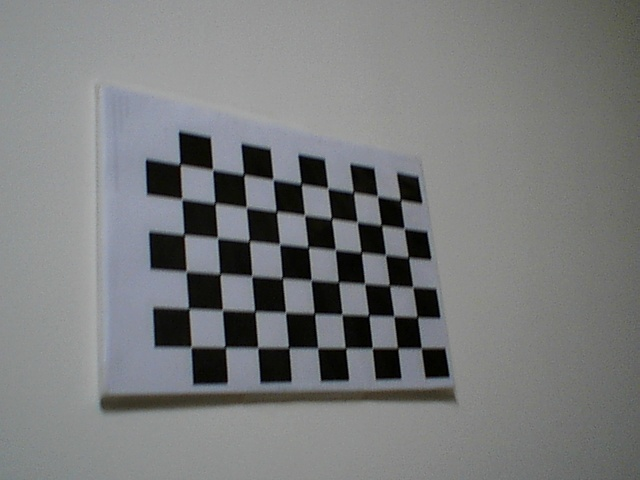

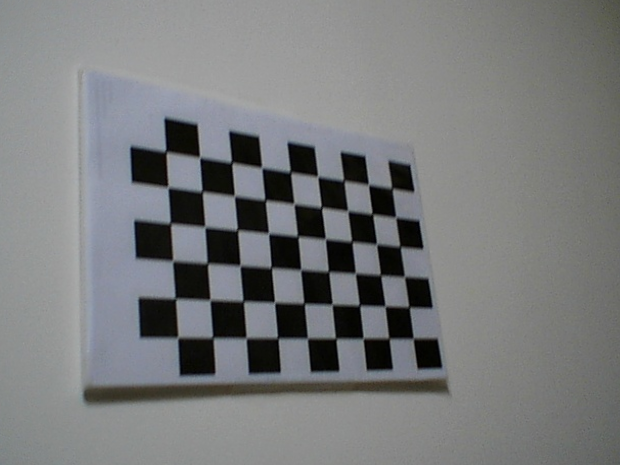

In [12]:
import cv2
import numpy as np


if 'mtx' not in globals() or 'dist' not in globals():
    print("Error: Camera calibration parameters not found. Run calibration first.")
    exit()


img = cv2.imread(r'/content/images/19.jpg')
if img is None:
    print("Error: Could not read the image file.")
    exit()

h, w = img.shape[:2]

print("Camera Matrix:\n", mtx)
print("Distortion Coefficients:\n", dist)


new_camera_mtx, roi = cv2.getOptimalNewCameraMatrix(mtx, dist, (w, h), alpha=0.6, newImgSize=(w, h))


undistorted_img = cv2.undistort(img, mtx, dist, None, new_camera_mtx)


x, y, w, h = roi
undistorted_img = undistorted_img[y:y+h, x:x+w]


cv2_imshow(img)
cv2_imshow(undistorted_img)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [13]:
import cv2
import numpy as np


checkerboard_size = (6, 9)


cube_size = 1
cube_points = np.float32([
    [0, 0, 0], [cube_size, 0, 0], [cube_size, cube_size, 0], [0, cube_size, 0],
    [0, 0, -cube_size], [cube_size, 0, -cube_size], [cube_size, cube_size, -cube_size], [0, cube_size, -cube_size]
])


def draw_cube(img, corners, imgpts):
    imgpts = np.int32(imgpts).reshape(-1, 2)


    img = cv2.drawContours(img, [imgpts[:4]], -1, (0, 255, 0), 2)


    for i, j in zip(range(4), range(4, 8)):
        img = cv2.line(img, tuple(imgpts[i]), tuple(imgpts[j]), (255, 0, 0), 2)


    img = cv2.drawContours(img, [imgpts[4:]], -1, (0, 0, 255), 2)

    return img


cap = cv2.VideoCapture(0)

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, checkerboard_size, None)

    if ret:

        corners = cv2.cornerSubPix(gray, corners, (11, 11), (-1, -1),
                                   (cv2.TermCriteria_EPS + cv2.TermCriteria_MAX_ITER, 30, 0.001))


        ret, rvecs, tvecs = cv2.solvePnP(objp, corners, mtx, dist)


        for i in range(0, len(corners), 5):
            square_origin = np.float32([objp[i]])
            cube_3d = cube_points + square_origin
            imgpts, _ = cv2.projectPoints(cube_3d, rvecs, tvecs, mtx, dist)
            frame = draw_cube(frame, corners, imgpts)


    cv2_imshow(frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()